# Installation

In [ ]:
%matplotlib inline
!pip install mediapipe
!pip install sacrebleu
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing Dependencies

In [ ]:
from __future__ import unicode_literals, print_function, division
import string
import gc
import re
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import sacrebleu
import jiwer
import nltk
nltk.download('punkt')
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
import pickle
from scipy.stats import skew
import cv2
import math
from google.colab import files
from google.colab.patches import cv2_imshow
import numpy as np
from string import printable
from re import X
from IPython.core import formatters
import mediapipe
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import xml.etree.ElementTree as ET
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from io import open
import unicodedata

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'



# Preparing Data



In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

MAX_LENGTH =  300

In [ ]:
videos = ['/content/rachel1.mp4', '/content/1-Ben-Introduction-SD.mov']
xml = ['/content/xml_extract_Rachel_2012-01-27_sc51_9.xml', 'xml_extract_1-Ben-Introduction_17.xml']

sequences =  []
translatedSequences =  []
AllSigns = []
AllFrames = []
AllFramesUncompressed = []
Labels = []

for video, xml in zip(videos, xml):

  capture = cv2.VideoCapture(video)
  count = 0
  frames = []
  frameNr = 0
  
  while (True):
      success, frame = capture.read()
      if success:
          frame = cv2.resize(frame, (320,240), interpolation = cv2.INTER_AREA)
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
          frames.append(frame)
      else:
          break
      count = count+1
  capture.release()

  print(len(frames))

  tree = ET.parse(xml)
  
  # getting the parent tag of
  # the xml document
  root = tree.getroot()
  
  # printing the root (parent) tag
  # of the xml document, along with
  # its memory location
  print(root)
  
  # printing the attributes of the
  # first tag from the parent
  print(root[0].attrib)
  
  # printing the text contained within
  # first subtag of the 5th tag from
  # the parent
  print(root[0][0][3][0][0][0][2])

  utterances= tree.findall('.//UTTERANCE')
  signs = utterances[1][3].findall('.//SIGN')
  UtteranceSigns = utterances[1][3].findall('.//SIGN')

  for sign  in tree.findall('.//SIGN'):
    # check if exists in unique_list or not
    if sign[0].text not in AllSigns:
      AllSigns.append(sign[0].text)

  label_map1 = {num:label for num, label in enumerate(AllSigns)}
  label_map2 = {label:num for num, label in enumerate(AllSigns)}

  
  for utterance in utterances:
      UtteranceSigns = utterance[3].findall('.//SIGN')
      UtteranceSignsSorted = sorted(UtteranceSigns, key=lambda x: x[13].get('START_FRAME'))
      utteranceFrameSigns = []
      signIDs = []
      currentSignId = len(label_map2) + 2
      FrameSequence = []
      FrameSequenceUncompressed = []
      SignSequence = ""
      a=0
      for sign in UtteranceSignsSorted:
        if sign.get('ID') not in signIDs:
          signIDs.append(sign.get('ID'))
          for frame_num in range(int(int(sign[13].get('START_FRAME'))/1000),int(int(sign[13].get('END_FRAME'))/1000)):
            if (frame_num - (int(int(sign[13].get('START_FRAME'))/1000)) ) % 3 == 0:
              FrameSequence.append(frames[frame_num-1].flatten())
              FrameSequenceUncompressed.append(frames[frame_num-1])
              utteranceFrameSigns.append(label_map2[sign[0].text])
          if(currentSignId != label_map2[sign[0].text]) :
            #SignSequence = SignSequence + sign[0].text.replace('\'', '').replace('\"', '').replace(' ', '') + " "
            SignSequence = SignSequence + sign[0].text.replace('\'', '').replace('\"', '').replace(' ', '') + " "
            currentSignId = label_map2[sign[0].text]
      Labels.append(utteranceFrameSigns)
      translatedSequences.append(normalizeString(utterance[0].text))
      sequences.append(normalizeString(SignSequence))
      AllFrames.append(FrameSequence)
      AllFramesUncompressed.append(FrameSequenceUncompressed)

6996
<Element 'SIGNSTREAM_DAI' at 0x7f6b1cb982f0>
{}
<Element 'UTTERANCES' at 0x7f6b1cb98bf0>
4409
<Element 'SIGNSTREAM_DAI' at 0x7f6b0c070770>
{}
<Element 'UTTERANCES' at 0x7f6b0c070f50>


In [ ]:
label_map1

{0: "'CAR'",
 1: "'BREAK-DOWN'",
 2: '\'(1h)5"wave no"\'',
 3: "'EVERYDAY+'",
 4: "'IX-3p:i'",
 5: "'ns-fs-JOHN'",
 6: "'DRIVE'",
 7: "'IX-3p:j'",
 8: "'ns-fs-MARY'",
 9: "'TO/UNTIL'",
 10: "'WORK'",
 11: "'(1h)part:indef'",
 12: "'(1h)KEY'",
 13: "'IX-loc:i'",
 14: "'IX-1p'",
 15: "'HAVE'",
 16: "'CORRECT'",
 17: "'FOR'",
 18: "'A-OK'",
 19: "'SURPRISE'",
 20: "'CANNOT'",
 21: "'THINK+MARRY'",
 22: "'NOT'",
 23: "'RAIN'",
 24: "'WONDER'",
 25: "'THINK'",
 26: "'MARRY'",
 27: "'#NO'",
 28: "'HAPPEN'",
 29: "'TEND'",
 30: "'MAYBE'",
 31: "'RUN-OUT'",
 32: "'#GAS'",
 33: "'part:indef'",
 34: "'(1h)TEND'",
 35: "'ns-fs-AMY'",
 36: "'SCHOOL+'",
 37: "'MALE-COUSIN'",
 38: "'REMEMBER'",
 39: "'IX-2p'",
 40: "'LONG-AGO+'",
 41: "'DRIVE+'",
 42: "'FINISH-shake'",
 43: "'CHECK'",
 44: "'NONE/NOTHING'",
 45: "'fs-EVEN'",
 46: "'LITTLE-BIT'",
 47: "'(5)ACCIDENT'",
 48: "'IX-loc:j'",
 49: "'fs-TRUCK'",
 50: '\'5"wave no"\'',
 51: "'IX-loc:k'",
 52: "'#CAR'",
 53: "'FINE+'",
 54: "'FUTURE'",
 55: "

In [ ]:
label_map2

{"'CAR'": 0,
 "'BREAK-DOWN'": 1,
 '\'(1h)5"wave no"\'': 2,
 "'EVERYDAY+'": 3,
 "'IX-3p:i'": 4,
 "'ns-fs-JOHN'": 5,
 "'DRIVE'": 6,
 "'IX-3p:j'": 7,
 "'ns-fs-MARY'": 8,
 "'TO/UNTIL'": 9,
 "'WORK'": 10,
 "'(1h)part:indef'": 11,
 "'(1h)KEY'": 12,
 "'IX-loc:i'": 13,
 "'IX-1p'": 14,
 "'HAVE'": 15,
 "'CORRECT'": 16,
 "'FOR'": 17,
 "'A-OK'": 18,
 "'SURPRISE'": 19,
 "'CANNOT'": 20,
 "'THINK+MARRY'": 21,
 "'NOT'": 22,
 "'RAIN'": 23,
 "'WONDER'": 24,
 "'THINK'": 25,
 "'MARRY'": 26,
 "'#NO'": 27,
 "'HAPPEN'": 28,
 "'TEND'": 29,
 "'MAYBE'": 30,
 "'RUN-OUT'": 31,
 "'#GAS'": 32,
 "'part:indef'": 33,
 "'(1h)TEND'": 34,
 "'ns-fs-AMY'": 35,
 "'SCHOOL+'": 36,
 "'MALE-COUSIN'": 37,
 "'REMEMBER'": 38,
 "'IX-2p'": 39,
 "'LONG-AGO+'": 40,
 "'DRIVE+'": 41,
 "'FINISH-shake'": 42,
 "'CHECK'": 43,
 "'NONE/NOTHING'": 44,
 "'fs-EVEN'": 45,
 "'LITTLE-BIT'": 46,
 "'(5)ACCIDENT'": 47,
 "'IX-loc:j'": 48,
 "'fs-TRUCK'": 49,
 '\'5"wave no"\'': 50,
 "'IX-loc:k'": 51,
 "'#CAR'": 52,
 "'FINE+'": 53,
 "'FUTURE'": 54,
 "'BUO

In [ ]:
skinMask360Sequences= np.loadtxt('360Arrays.txt')
print('')
print(skinMask360Sequences.shape)
skinMask360Sequences = skinMask360Sequences.reshape(len(skinMask360Sequences), 93, 1080)
print(skinMask360Sequences.shape)


(56, 100440)
(56, 93, 1080)


In [ ]:
handSequences= np.loadtxt('HandArrays.txt')
print('')
print(handSequences.shape)
handSequences = handSequences.reshape(len(handSequences), 93, 126)
print(handSequences.shape)


(56, 11718)
(56, 93, 126)


In [ ]:
label_map1[198] = "error"

In [ ]:
label_map2["error"] = 198

# Training LSTM Classifiers

#Model 1

In [ ]:
padded_inputs1 = tf.keras.preprocessing.sequence.pad_sequences(
    handSequences, padding="post", value=-1
)
padded_outputs1 = tf.keras.preprocessing.sequence.pad_sequences(
    Labels, padding="post", value=-1
)

trueOutputs1 = []
for sequence in padded_outputs1:
  newSeq = []
  for value in sequence:
      newProbability = [0.] * len(label_map1)
      newProbability[value] = 1.0
      newSeq.append(newProbability)
  trueOutputs1.append(newSeq)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(padded_inputs1, trueOutputs1, test_size=0.05, random_state=42)

In [ ]:
model1 = Sequential()
model1.add(tf.keras.layers.Masking(mask_value=-1.,
                                  input_shape=(len(X_train1[0]), len(X_train1[0][0]))))
model1.add(LSTM(128, return_sequences=True, activation='relu',))
model1.add(LSTM(64, return_sequences=True, activation='relu'))
model1.add(Dense(len(label_map1), activation='softmax'))
model1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history1 = model1.fit(np.array(X_train1), np.array(y_train1), validation_split=0.33, epochs=100, batch_size=1,verbose=1, shuffle=False)
model1.summary()

model1.save("model1")
with open('trainHistory1Dict', 'wb') as file_pi:
    pickle.dump(history1.history, file_pi)

Epoch 1/100
35/35 [==============================] - 8s 175ms/step - loss: 1.9072 - categorical_accuracy: 0.0324 - val_loss: 2.0156 - val_categorical_accuracy: 0.0408
Epoch 2/100
35/35 [==============================] - 5s 156ms/step - loss: 1.9017 - categorical_accuracy: 0.0546 - val_loss: 2.0150 - val_categorical_accuracy: 0.0408
Epoch 3/100
35/35 [==============================] - 5s 154ms/step - loss: 1.8972 - categorical_accuracy: 0.0546 - val_loss: 2.0146 - val_categorical_accuracy: 0.0408
Epoch 4/100
35/35 [==============================] - 5s 152ms/step - loss: 1.8928 - categorical_accuracy: 0.0546 - val_loss: 2.0142 - val_categorical_accuracy: 0.0408
Epoch 5/100
35/35 [==============================] - 5s 153ms/step - loss: 1.8885 - categorical_accuracy: 0.0546 - val_loss: 2.0139 - val_categorical_accuracy: 0.0408
Epoch 6/100
35/35 [==============================] - 6s 161ms/step - loss: 1.8843 - categorical_accuracy: 0.0546 - val_loss: 2.0137 - val_categorical_accuracy: 0.040

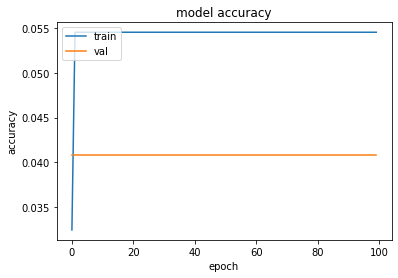

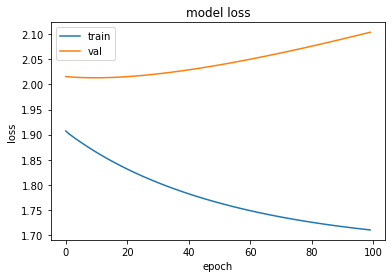

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history1.history['categorical_accuracy'])
plt.plot(history1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m1Accuracy.png")
plt.show()
plt.clf()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m1Loss.png")
plt.show()
plt.clf()

In [ ]:
prediction1 = model1.predict(X_test1)
tempP1 = prediction1.argmax(axis=-2)

truth1 = np.array(y_test1)
tempT1 = truth1.argmax(axis=-1)

TruePredicitions1 = []
groundTruths1 = []

for P, T in zip(tempP1, tempT1):

  sequenceP = ""
  currentSignId = len(label_map2) + 2
  for valueP, valueT in zip(P, T):
    if valueP == len(label_map1)-1:
      continue
    if valueT == len(label_map1)-1:
      continue
    if(currentSignId != valueP) :
      sequenceP = sequenceP + label_map1.get(valueP).replace('\'', '').replace('\"', '').replace(' ', '') + " "
      currentSignId = valueP
  sequenceP = normalizeString(sequenceP)
  TruePredicitions1.append(sequenceP)

  for L, translated in zip(Labels, translatedSequences):
    tempTruth = list(filter(lambda a: a != len(label_map1)-1, T))
    if tempTruth == L:
      groundTruths1.append(translated)
      break; 

1/1 [==============================] - 1s 533ms/step


#Model 2

In [ ]:
padded_inputs2 = tf.keras.preprocessing.sequence.pad_sequences(
    skinMask360Sequences, padding="post", value=-1
)
padded_outputs2 = tf.keras.preprocessing.sequence.pad_sequences(
    Labels, padding="post", value=-1
)

trueOutputs2 = []
for sequence in padded_outputs2:
  newSeq = []
  for value in sequence:
      newProbability = [0.] * len(label_map1)
      newProbability[value] = 1.0
      newSeq.append(newProbability)
  trueOutputs2.append(newSeq)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(padded_inputs2, trueOutputs2, test_size=0.05, random_state=42)

In [ ]:
model2 = Sequential()
model2.add(tf.keras.layers.Masking(mask_value=-1.,
                                  input_shape=(len(X_train2[0]), len(X_train2[0][0]))))
model2.add(LSTM(128, return_sequences=True, activation='relu',))
model2.add(LSTM(64, return_sequences=True, activation='relu'))
model2.add(Dense(len(label_map1), activation='softmax'))
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history2 = model2.fit(np.array(X_train2), np.array(y_train2), validation_split=0.33, epochs=100, batch_size=1,verbose=1, shuffle=False)
model2.summary()

model2.save("model2")
with open('trainHistory2Dict', 'wb') as file_pi:
    pickle.dump(history2.history, file_pi)

Epoch 1/100
35/35 [==============================] - 8s 173ms/step - loss: 317.6445 - categorical_accuracy: 0.0051 - val_loss: 530.8962 - val_categorical_accuracy: 0.0063
Epoch 2/100
35/35 [==============================] - 6s 161ms/step - loss: 5004.8608 - categorical_accuracy: 0.0068 - val_loss: 1374087.2500 - val_categorical_accuracy: 0.0047
Epoch 3/100
35/35 [==============================] - 6s 158ms/step - loss: 45461.0234 - categorical_accuracy: 0.0111 - val_loss: 4757.1328 - val_categorical_accuracy: 0.0125
Epoch 4/100
35/35 [==============================] - 5s 156ms/step - loss: 2472.1135 - categorical_accuracy: 0.0051 - val_loss: 935.3737 - val_categorical_accuracy: 0.0125
Epoch 5/100
35/35 [==============================] - 5s 155ms/step - loss: 9341.7061 - categorical_accuracy: 0.0094 - val_loss: 787.6198 - val_categorical_accuracy: 0.0000e+00
Epoch 6/100
35/35 [==============================] - 5s 157ms/step - loss: 623.1569 - categorical_accuracy: 0.0085 - val_loss: 443.

In [ ]:
print(history2.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


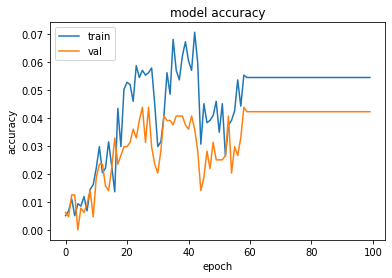

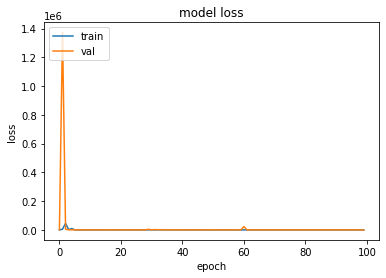

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m2Accuracy.png")
plt.show()
plt.clf()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m2Loss.png")
plt.show()
plt.clf()

In [ ]:
len(label_map1)

199

In [ ]:
prediction2 = model2.predict(X_test2)
tempP2 = prediction2.argmax(axis=-2)

truth2 = np.array(y_test2)
tempT2 = truth2.argmax(axis=-1)

TruePredicitions2 = []
groundTruths2 = []

for P, T in zip(tempP2, tempT2):

  sequenceP = ""
  currentSignId = len(label_map2) + 2
  for valueP, valueT in zip(P, T):
    if valueP == len(label_map1)-1:
      continue
    if valueT == len(label_map1)-1:
      continue
    if(currentSignId != valueP) :
      sequenceP = sequenceP + label_map1.get(valueP).replace('\'', '').replace('\"', '').replace(' ', '') + " "
      currentSignId = valueP
  sequenceP = normalizeString(sequenceP)
  TruePredicitions2.append(sequenceP)

  for L, translated in zip(Labels, translatedSequences):
    tempTruth = list(filter(lambda a: a != len(label_map1)-1, T))
    if tempTruth == L:
      groundTruths2.append(translated)
      break; 

1/1 [==============================] - 0s 391ms/step


In [ ]:
TruePredicitions2

['car', 'car', 'car']

In [ ]:
groundTruths2

[' the car didn t break down . ',
 ' the car is broken . ',
 ' the set up of the two categories was based on edward hall s analysis from the idea he presented years ago . ']

#Model 3

In [ ]:
padded_inputs3 = tf.keras.preprocessing.sequence.pad_sequences(
    AllFrames, padding="post", value=-1
)

padded_outputs3 = tf.keras.preprocessing.sequence.pad_sequences(
    Labels, padding="post", value=-1
)

trueInputs3 = np.array(padded_inputs3).reshape(len(padded_inputs3), len(padded_inputs3[0]), 240, 320, 1)

trueOutputs3 = []
for sequence in padded_outputs3:
  newSeq = []
  for value in sequence:
      newProbability = [0.] * len(label_map1)
      newProbability[value] = 1.0
      newSeq.append(newProbability)
  trueOutputs3.append(newSeq)



In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(trueInputs3, trueOutputs3, test_size=0.05, random_state=42)

In [ ]:
model3 = Sequential()
model3.add(tf.keras.layers.ConvLSTM2D(
        filters=1,
        kernel_size=(4, 4),
        return_sequences=True,
        activation='relu',
        input_shape=(len(padded_inputs3[0]), 240, 320, 1)
        ))
model3.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model3.add(Dense(len(label_map1), activation='softmax'))
model3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history3 = model3.fit(np.array(X_train3), np.array(y_train3), validation_split=0.33, epochs=100, batch_size=1)
model3.summary()

model3.save("model3")
with open('trainHistory3Dict', 'wb') as file_pi:
    pickle.dump(history3.history, file_pi)

Epoch 1/100
35/35 [==============================] - 10s 241ms/step - loss: 4.8125 - categorical_accuracy: 0.6363 - val_loss: 4.5914 - val_categorical_accuracy: 0.6440
Epoch 2/100
35/35 [==============================] - 8s 230ms/step - loss: 4.2025 - categorical_accuracy: 0.7057 - val_loss: 4.4944 - val_categorical_accuracy: 0.6434
Epoch 3/100
35/35 [==============================] - 8s 232ms/step - loss: 2.7884 - categorical_accuracy: 0.7502 - val_loss: 1.9124 - val_categorical_accuracy: 0.6493
Epoch 4/100
35/35 [==============================] - 8s 234ms/step - loss: 1.3581 - categorical_accuracy: 0.7601 - val_loss: 1.9834 - val_categorical_accuracy: 0.6505
Epoch 5/100
35/35 [==============================] - 8s 234ms/step - loss: 1.2797 - categorical_accuracy: 0.7680 - val_loss: 2.0110 - val_categorical_accuracy: 0.6505
Epoch 6/100
35/35 [==============================] - 8s 232ms/step - loss: 1.2933 - categorical_accuracy: 0.7656 - val_loss: 2.0449 - val_categorical_accuracy: 0.64

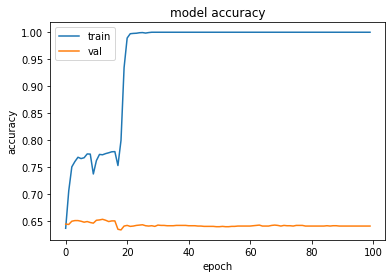

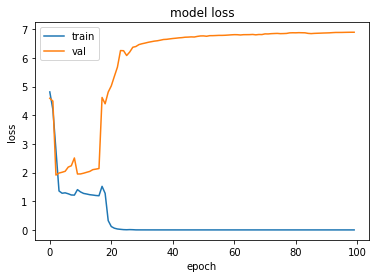

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history3.history['categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m3Accuracy.png")
plt.show()
plt.clf()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m3Loss.png")
plt.show()
plt.clf()

In [ ]:
prediction3 = model3.predict(X_test3)
tempP3 = prediction3.argmax(axis=-2)

truth3 = np.array(y_test3)
tempT3 = truth3.argmax(axis=-1)

TruePredicitions3 = []
groundTruths3 = []

for P, T in zip(tempP3, tempT3):

  sequenceP = ""
  currentSignId = len(label_map2) + 2
  for valueP, valueT in zip(P, T):
    if valueP == len(label_map1)-1:
      continue
    if valueT == len(label_map1)-1:
      continue
    if(currentSignId != valueP) :
      sequenceP = sequenceP + label_map1.get(valueP).replace('\'', '').replace('\"', '').replace(' ', '') + " "
      currentSignId = valueP
  sequenceP = normalizeString(sequenceP)
  TruePredicitions3.append(sequenceP)

  for L, translated in zip(Labels, translatedSequences):
    tempTruth = list(filter(lambda a: a != len(label_map1)-1, T))
    if tempTruth == L:
      groundTruths3.append(translated)
      break; 

1/1 [==============================] - 0s 345ms/step


# Training Encoder Decoder Translator

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    pairs = [list(a) for a in zip(translatedSequences, sequences)]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH # and p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 56 sentence pairs
Trimmed to 56 sentence pairs
Counting words...
Counted words:
fra 205
eng 233
['express sign current topic road express through h talkwg minor', ' it can be expressed through speech or through sign language . ']


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

0m 16s (- 5m 20s) (500 5%) 2.9430
0m 32s (- 4m 49s) (1000 10%) 2.2667
0m 48s (- 4m 35s) (1500 15%) 1.4908
1m 5s (- 4m 20s) (2000 20%) 0.6393
1m 21s (- 4m 5s) (2500 25%) 0.3129
1m 38s (- 3m 50s) (3000 30%) 0.2021
1m 55s (- 3m 35s) (3500 35%) 0.0800
2m 13s (- 3m 19s) (4000 40%) 0.0478
2m 30s (- 3m 4s) (4500 45%) 0.0587
2m 47s (- 2m 47s) (5000 50%) 0.0152
3m 5s (- 2m 31s) (5500 55%) 0.0121
3m 22s (- 2m 15s) (6000 60%) 0.0098
3m 39s (- 1m 58s) (6500 65%) 0.0083
3m 57s (- 1m 41s) (7000 70%) 0.0071
4m 14s (- 1m 24s) (7500 75%) 0.0062
4m 32s (- 1m 8s) (8000 80%) 0.0057
4m 49s (- 0m 51s) (8500 85%) 0.0053
5m 6s (- 0m 34s) (9000 90%) 0.0046
5m 24s (- 0m 17s) (9500 95%) 0.0043
5m 41s (- 0m 0s) (10000 100%) 0.0040


<Figure size 432x288 with 0 Axes>

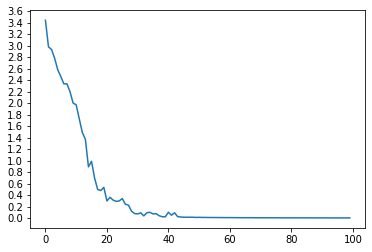

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=500)

# Results

In [ ]:
train_sentences = translatedSequences
tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) for sent in train_sentences]
n = 1
train_data, padded_vocab = padded_everygram_pipeline(n, tokenized_text)
modelP = MLE(n)
modelP.fit(train_data, padded_vocab)

def evaluatePredictions(encoder, decoder, testX_sentences, testY_sentences, filename):
  f = open(filename,'w') 
  PER = []
  WER =[]
  BLEU = []
  OutputSentences = []

  count = 0
  for untranslated, groundTranslation in zip(testX_sentences, testY_sentences):

    output_words, attentions = evaluate(encoder, decoder, untranslated)
    output_sentence = ' '.join(output_words)
    output_sentence = output_sentence.replace(' <EOS>', '')
    OutputSentences.append(output_sentence)

    bleu = sacrebleu.raw_corpus_bleu(output_sentence.lstrip().rstrip(), groundTranslation.lstrip().rstrip(), .01).score
    BLEU.append(bleu)

    error = jiwer.wer(groundTranslation, output_sentence)
    WER.append(error)

  tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) 
                for sent in OutputSentences]

  test_data, _ = padded_everygram_pipeline(n, tokenized_text)

  for i, test in enumerate(test_data):
    PER.append(modelP.perplexity(test))

  print("Perplexity Average: ")
  print(str(np.mean(PER)))
  print("\nPerplexity Standard Deviation: ")
  print(str(np.std(PER)))
  print("\nPerplexity Skew: ")
  print(str(skew(PER)))

  print("\n\n\nWord error rate Average: ")
  print(str(np.mean(WER)))
  print("\nWord error rate Standard Deviation: ")
  print(str(np.std(WER)))
  print("\nWord error rate Skew: ")
  print(str(skew(WER)))

  print("\n\n\nBLEU Average: ")
  print(str(np.mean(BLEU)))
  print("\nBLEU Standard Deviation: ")
  print(str(np.std(BLEU)))
  print("\nBLEU Skew: ")
  print(str(skew(BLEU)))


  f.write("Perplexity Average: ")
  f.write(str(np.mean(PER)))
  f.write("\nPerplexity Standard Deviation: ")
  f.write(str(np.std(PER)))
  f.write("\nPerplexity Skew: ")
  f.write(str(skew(PER)))

  f.write("\n\n\nWord error rate Average: ")
  f.write(str(np.mean(WER)))
  f.write("\nWord error rate Standard Deviation: ")
  f.write(str(np.std(WER)))
  f.write("\nWord error rate Skew: ")
  f.write(str(skew(WER)))

  f.write("\n\n\nBLEU Average: ")
  f.write(str(np.mean(BLEU)))
  f.write("\nBLEU Standard Deviation: ")
  f.write(str(np.std(BLEU)))
  f.write("\nBLEU Skew: ")
  f.write(str(skew(BLEU)))

  f.close()

In [ ]:
evaluatePredictions(encoder1, attn_decoder1, sequences, translatedSequences, 'testTranslationMetrics.txt')

Perplexity Average: 
110.10274795171154

Perplexity Standard Deviation: 
48.21151169324072

Perplexity Skew: 
0.12532779772224545



Word error rate Average: 
0.0

Word error rate Standard Deviation: 
0.0

Word error rate Skew: 
0.0



BLEU Average: 
100.00000000000003

BLEU Standard Deviation: 
1.4210854715202004e-14

BLEU Skew: 
0.0


In [ ]:
evaluatePredictions(encoder1, attn_decoder1, TruePredicitions1, groundTruths1, 'm1TranslationMetrics.txt')

Perplexity Average: 
94.81992806988019

Perplexity Standard Deviation: 
0.0

Perplexity Skew: 
0.0



Word error rate Average: 
1.4610389610389614

Word error rate Standard Deviation: 
0.42742204525214517

Word error rate Skew: 
0.11350363822155006



BLEU Average: 
100.00000000000004

BLEU Standard Deviation: 
0.0

BLEU Skew: 
0.0


In [ ]:
evaluatePredictions(encoder1, attn_decoder1, TruePredicitions2, groundTruths2, 'm2TranslationMetrics.txt')

Perplexity Average: 
94.81992806988019

Perplexity Standard Deviation: 
0.0

Perplexity Skew: 
0.0



Word error rate Average: 
1.4610389610389614

Word error rate Standard Deviation: 
0.42742204525214517

Word error rate Skew: 
0.11350363822155006



BLEU Average: 
100.00000000000004

BLEU Standard Deviation: 
0.0

BLEU Skew: 
0.0


In [ ]:
evaluatePredictions(encoder1, attn_decoder1, TruePredicitions3, groundTruths3, 'm3TranslationMetrics.txt')

Perplexity Average: 
57.39127261606357

Perplexity Standard Deviation: 
19.2504728128213

Perplexity Skew: 
0.30858875282353343



Word error rate Average: 
0.6744588744588745

Word error rate Standard Deviation: 
0.20973478698536813

Word error rate Skew: 
-0.2779899044128924



BLEU Average: 
66.6666666666667

BLEU Standard Deviation: 
47.140452079103184

BLEU Skew: 
-0.707106781186548


In [ ]:
!zip -r /content/m1.zip /content/model1
!zip -r /content/m2.zip /content/model2
!zip -r /content/m3.zip /content/model3

  adding: content/model1/ (stored 0%)
  adding: content/model1/variables/ (stored 0%)
  adding: content/model1/variables/variables.index (deflated 65%)
  adding: content/model1/variables/variables.data-00000-of-00001 (deflated 70%)
  adding: content/model1/assets/ (stored 0%)
  adding: content/model1/saved_model.pb (deflated 90%)
  adding: content/model1/keras_metadata.pb (deflated 90%)
  adding: content/model2/ (stored 0%)
  adding: content/model2/variables/ (stored 0%)
  adding: content/model2/variables/variables.index (deflated 63%)
  adding: content/model2/variables/variables.data-00000-of-00001 (deflated 45%)
  adding: content/model2/assets/ (stored 0%)
  adding: content/model2/saved_model.pb (deflated 90%)
  adding: content/model2/keras_metadata.pb (deflated 89%)
  adding: content/model3/ (stored 0%)
  adding: content/model3/variables/ (stored 0%)
  adding: content/model3/variables/variables.index (deflated 61%)
  adding: content/model3/variables/variables.data-00000-of-00001 (de